<a href="https://colab.research.google.com/github/naynikaw/HumanActionRecognition/blob/main/I3D_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [ ]:
# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

In [ ]:
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

In [ ]:
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print(labels)
print("Found %d labels." % len(labels))

['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'arm wrestling', 'arranging flowers', 'assembling computer', 'auctioning', 'baby waking up', 'baking cookies', 'balloon blowing', 'bandaging', 'barbequing', 'bartending', 'beatboxing', 'bee keeping', 'belly dancing', 'bench pressing', 'bending back', 'bending metal', 'biking through snow', 'blasting sand', 'blowing glass', 'blowing leaves', 'blowing nose', 'blowing out candles', 'bobsledding', 'bookbinding', 'bouncing on trampoline', 'bowling', 'braiding hair', 'breading or breadcrumbing', 'breakdancing', 'brush painting', 'brushing hair', 'brushing teeth', 'building cabinet', 'building shed', 'bungee jumping', 'busking', 'canoeing or kayaking', 'capoeira', 'carrying baby', 'cartwheeling', 'carving pumpkin', 'catching fish', 'catching or throwing baseball', 'catching or throwing frisbee', 'catching or throwing softball', 'celebrating', 'changing oil', 'changing wheel', 'checking tires', 'che

In [ ]:
def predict(sample_video):
  # Add a batch axis to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Sun Apr 24 07:14:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |            

In [2]:
!pip install mxnet-cu110

     |████████████████████████████████| 325.4 MB 31 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
!pip install gluoncv

     |████████████████████████████████| 1.3 MB 30.6 MB/s 


In [4]:
!pip install decord

     |████████████████████████████████| 13.6 MB 24.7 MB/s 


In [5]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np
import mxnet as mx
import gluoncv as gcv
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [6]:
import decord

Script to make train.txt file (walking:0, running:1, sitting:2)

In [7]:
import os

with open("train.txt", "w") as a:
    for path, subdirs, files in os.walk(r'/content/drive/MyDrive/new/walking'):
       for filename in files:
         f = os.path.join(path, filename)
         a.write(str(f) + " ")
         a.write(str(100) + " ")
         a.write(str(0) + os.linesep)

    for path, subdirs, files in os.walk(r'/content/drive/MyDrive/new/running'):
       for filename in files:
         f = os.path.join(path, filename)
         a.write(str(f) + " ")
         a.write(str(100) + " ")
         a.write(str(1) + os.linesep)

    for path, subdirs, files in os.walk(r'/content/drive/MyDrive/new/sitting'):
       for filename in files:
         f = os.path.join(path, filename)
         a.write(str(f) + " ")
         a.write(str(100) + " ")
         a.write(str(2) + os.linesep)


In [8]:
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]
transform_train = video.VideoGroupTrainTransform(size=(224, 224), scale_ratios=[1.0, 0.8], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
per_device_batch_size = 5
num_workers = 0
batch_size = per_device_batch_size * num_gpus

train_dataset = VideoClsCustom(root=os.path.expanduser('/content/drive/MyDrive/new'),
                               setting=os.path.expanduser('/content/train.txt'),
                               train=True,
                               new_length=32,
                               transform=transform_train,
                               video_loader=True,
                               use_decord=True)
print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 60 training samples.


In [9]:
mx.test_utils.list_gpus()

range(0, 1)

In [10]:
net = get_model(name='i3d_resnet50_v1_custom', nclass=3)
net.collect_params().reset_ctx(ctx)
print(net)

100%|██████████| 55344/55344 [00:01<00:00, 43228.32KB/s]


conv0_weight is done with shape:  (64, 3, 5, 7, 7)
batchnorm0_gamma is done with shape:  (64,)
batchnorm0_beta is done with shape:  (64,)
batchnorm0_running_mean is done with shape:  (64,)
batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv0_weight is done with shape:  (64, 64, 3, 1, 1)
layer1_0_batchnorm0_gamma is done with shape:  (64,)
layer1_0_batchnorm0_beta is done with shape:  (64,)
layer1_0_batchnorm0_running_mean is done with shape:  (64,)
layer1_0_batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv1_weight is done with shape:  (64, 64, 1, 3, 3)
layer1_0_batchnorm1_gamma is done with shape:  (64,)
layer1_0_batchnorm1_beta is done with shape:  (64,)
layer1_0_batchnorm1_running_mean is done with shape:  (64,)
layer1_0_batchnorm1_running_var is done with shape:  (64,)
layer1_0_conv2_weight is done with shape:  (256, 64, 1, 1, 1)
layer1_0_batchnorm2_gamma is done with shape:  (256,)
layer1_0_batchnorm2_beta is done with shape:  (256,)
layer1_0_batchnorm2_ru

100%|██████████| 208483/208483 [00:08<00:00, 25378.87KB/s]


I3D_ResNetV1(
  (first_stage): HybridSequential(
    (0): Conv3D(3 -> 64, kernel_size=(5, 7, 7), stride=(2, 2, 2), padding=(2, 3, 3), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(relu)
    (3): MaxPool3D(size=(1, 3, 3), stride=(2, 2, 2), padding=(0, 1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  )
  (pool2): MaxPool3D(size=(2, 1, 1), stride=(2, 1, 1), padding=(0, 0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (res_layers): HybridSequential(
    (0): HybridSequential(
      (0): Bottleneck(
        (bottleneck): HybridSequential(
          (0): Conv3D(64 -> 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
          (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
          (2): Activation(relu)
          (3): Conv3D(64 -> 64, kernel_size=(1, 3, 3), stride=(1

In [11]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [40, 80, 100]

# Stochastic gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.001, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In [12]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [13]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc'])

[Epoch 0] train=0.900000 loss=0.388714 time: 17.282243
[Epoch 1] train=0.866667 loss=0.343982 time: 17.270428
[Epoch 2] train=0.933333 loss=0.213409 time: 16.788842
[Epoch 3] train=0.966667 loss=0.223995 time: 17.170578
[Epoch 4] train=0.916667 loss=0.209591 time: 17.324693
[Epoch 5] train=0.966667 loss=0.178715 time: 17.155596
[Epoch 6] train=0.916667 loss=0.208972 time: 16.965913
[Epoch 7] train=0.900000 loss=0.218786 time: 17.081175
[Epoch 8] train=0.966667 loss=0.163973 time: 17.414699
[Epoch 9] train=0.916667 loss=0.150529 time: 17.160815


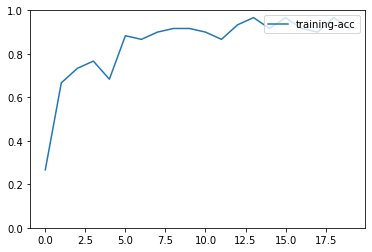

In [22]:
epochs = 10
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        if i == 100:
            break

    name, acc = train_metric.get()

    # Update history and print metrics
    train_history.update([acc])
    print('[Epoch %d] train=%f loss=%f time: %f' %
        (epoch, acc, train_loss / (i+1), time.time()-tic))

# We can plot the metric scores with:
train_history.plot()

Script to make val.txt

In [17]:
import os

with open("val.txt", "w") as a:
    for path, subdirs, files in os.walk(r'/content/drive/MyDrive/new/test/walking'):
       for filename in files:
         f = os.path.join(path, filename)
         a.write(str(f) + " ")
         a.write(str(100) + " ")
         a.write(str(0) + os.linesep)

    for path, subdirs, files in os.walk(r'/content/drive/MyDrive/new/test/running'):
       for filename in files:
         f = os.path.join(path, filename)
         a.write(str(f) + " ")
         a.write(str(100) + " ")
         a.write(str(1) + os.linesep)

    for path, subdirs, files in os.walk(r'/content/drive/MyDrive/new/test/sitting'):
       for filename in files:
         f = os.path.join(path, filename)
         a.write(str(f) + " ")
         a.write(str(100) + " ")
         a.write(str(2) + os.linesep)


In [23]:
net.save_parameters("parameters.params")

In [24]:
!python inference1.py --data-list val.txt --model i3d_resnet50_v1_custom --resume-params parameters.params --num-classes 3

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '
Namespace(data_aug='v1', data_dir='', data_list='val.txt', dtype='float32', fast_temporal_stride=2, gpu_id=0, hashtag='', input_size=224, log_interval=10, logging_file='predictions.log', mode=None, model='i3d_resnet50_v1_custom', need_root=False, new_height=256, new_length=32, new_step=1, new_width=340, num_classes=3, num_crop=1, num_segments=1, resume_params='parameters.params', save_dir='./predictions', save_logits=False, save_preds=False, slow_temporal_stride=16, slowfast=False, ten_crop=False, three_crop=False, use_decord=True, use_pretrained=True, video_loader=True)
[07:27:24] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8005 != compiled-

In [30]:
!python inference.py --data-list val.txt --model i3d_resnet50_v1_custom --resume-params parameters.params --num-classes 3

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '
Namespace(data_aug='v1', data_dir='', data_list='val.txt', dtype='float32', fast_temporal_stride=2, gpu_id=0, hashtag='', input_size=224, log_interval=10, logging_file='predictions.log', mode=None, model='i3d_resnet50_v1_custom', need_root=False, new_height=256, new_length=32, new_step=1, new_width=340, num_classes=3, num_crop=1, num_segments=1, resume_params='parameters.params', save_dir='./predictions', save_logits=False, save_preds=False, slow_temporal_stride=16, slowfast=False, ten_crop=False, three_crop=False, use_decord=True, use_pretrained=False, video_loader=True)
conv0_weight is done with shape:  (64, 3, 5, 7, 7)
batchnorm0_gamma is done with shape:  

In [22]:
!python test_recognizer.py --model i3d_resnet50_v1_kinetics400 --resume-params parameters.params --num-classes 3 --train-list /content/train.txt --val-list /content/val.txt --new-length 32

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '
Namespace(batch_norm=False, batch_size=32, benchmark=False, calib_mode='naive', calibration=False, crop_ratio=0.875, data_aug='v1', data_dir='/root/.mxnet/datasets/ucf101/rawframes', dataset='kinetics400', deploy=False, dtype='float32', eval=False, fast_temporal_stride=2, hard_weight=0.5, hashtag='', input_5d=True, input_size=224, label_smoothing=False, last_gamma=False, log_interval=50, logging_file='train.log', lr=0.1, lr_decay=0.1, lr_decay_epoch='40,60', lr_decay_period=0, lr_mode='step', mixup=False, mixup_alpha=0.2, mixup_off_epoch=0, mode=None, model='i3d_resnet50_v1_kinetics400', model_prefix=None, momentum=0.9, new_height=256, new_length=32, new_step=

In [19]:
classes = ["walking","running","sitting"]
net1 = gcv.model_zoo.get_model(name='i3d_resnet50_v1_custom', nclass=3,
                      classes=classes,
                      pretrained_base=False,
                      ctx=ctx)


In [20]:
net1.load_parameters("parameters.params")

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms import video
from gluoncv import utils
from gluoncv.model_zoo import get_model

In [25]:
from gluoncv.utils.filesystem import try_import_decord
decord = try_import_decord()

# url = 'https://github.com/AlexanderMelde/SPHAR-Dataset/blob/master/videos/walking/okutama_1.1.10_Walking_57.mp4'
# video_fname = utils.download(url)
vr = decord.VideoReader("/content/okutama_2.2.5_Walking_51.mp4")
frame_id_list = range(0, 64, 2)
video_data = vr.get_batch(frame_id_list).asnumpy()
clip_input = [video_data[vid, :, :, :] for vid, _ in enumerate(frame_id_list)]

In [26]:
transform_fn = video.VideoGroupValTransform(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
clip_input = transform_fn(clip_input)
clip_input = np.stack(clip_input, axis=0)
clip_input = clip_input.reshape((-1,) + (32, 3, 224, 224))
clip_input = np.transpose(clip_input, (0, 2, 1, 3, 4))
print('Video data is downloaded and preprocessed.')

ValueError: ignored

In [29]:
data = decord.VideoReader("/content/okutama_2.2.5_Walking_51.mp4")
frames = data.get_batch(range(0,32))
print(frames.shape)

(32, 86, 90, 3)
